In [1]:
import sys
sys.path
sys.path.append('../service/')

print(sys.executable)

/home/stefan/coding/notebooks/env/bin/python


In [2]:
# standart libs
import random
import copy
from operator import itemgetter

# 3rd party libs
import pandas as pd
import numpy as np
import gempy as gp
import matplotlib.pyplot as plt

# local
import functions as fun

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Init

In [3]:
# instantiate the geo_model
geo_model = gp.create_model("BaseModel")

# defautl data
geo_model = gp.init_data(
    geo_model,
    extent=[0, 1, 0, 1, 0, 1],
    resolution=[5, 5, 5]
)

# compile theno function
gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_run',
)

Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                     values
range              1.73205
$C_o$            0.0714286
drift equations        [3]


# Model 1

## Data

In [4]:
# meta
geo_model_extent = [0,1000,0,1000,0,1000]
section = {
    'p1': [0, 500],
    'p2': [1000, 500],
    'resolution': [200, 200]
}

# sereis
series_df = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
series_df.loc[0] = { 'order_series': 0, 'name': 'Basement_Series', 'isfault': False }
series_df.loc[1] = { 'order_series': 1, 'name': 'Strat_Series', 'isfault': False }

# surfaces
surfaces_df = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
surfaces_df.loc[0] = { 'name': 'basement', 'serie': 'Basement_Series', 'order_surface': 0 }
surfaces_df.loc[2] = { 'name': 'rock1', 'serie': 'Strat_Series', 'order_surface': 1 }
surfaces_df.loc[1] = { 'name': 'rock2', 'serie': 'Strat_Series', 'order_surface': 2 }

In [5]:
# geoData
surface_points_input_data = pd.read_csv('./data/model2_surface_points.csv')
orientaions_input_data = pd.read_csv('./data/model2_orientations.csv')

# Format geological_input_data
surface_points_original_df = surface_points_input_data[['X', 'Y', 'Z', 'formation']]

# rename colums
surface_points_original_df.columns = ['X', 'Y', 'Z', 'surface']

# add distribution type and parameter
surface_points_original_df['param1'] = 10

# Orientaions
orientations_original_df = orientaions_input_data[['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation']]

## Set model

In [6]:
# Set meta data
gp.init_data(
    geo_model,
    extent=[0, 1000, 0, 1000, 0, 1000],
    resolution=[5, 5, 5])

# Set section grid
section_dict = {'section': (
    section['p1'],
    section['p2'],
    section['resolution']
)}
# geo_model.grid.set_inactive('regular')
geo_model.set_section_grid(section_dict=section_dict)

# Set series and surfaces
fun.update_series(geo_model, series_df)
fun.update_surfaces(geo_model, surfaces_df)

# Set surface points and orientations
geo_model.set_surface_points(surface_points_original_df, update_surfaces=False)
geo_model.set_orientations(orientations_original_df, update_surfaces=False)

# Map series to surfaces
mapping_object = fun.creat_mapping_object(surfaces_df, series_df)
gp.map_series_to_surfaces(
    geo_model=geo_model,
    mapping_object=mapping_object
)

# Set faults if any
if np.any(series_df['isfault']):

    fault_series = series_df[series_df['isfault']]['name']
    geo_model.set_is_fault(fault_series)

# Update to interpolator
geo_model.update_to_interpolator()

Active grids: ['regular']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
HOTFIX in update_surfaces()


True

# compute solution

In [7]:
solution = gp.compute_model(model=geo_model, sort_surfaces=False)

/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


# postprocessing

## get boolen matrix

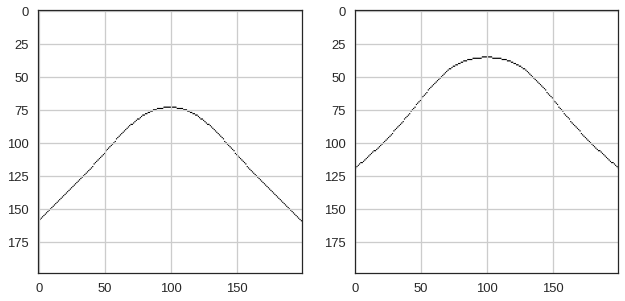

In [8]:
# plot for sanity check
fig, (ax1, ax2) = plt.subplots(1, 2)
bigger_level_0 = fun.compute_boolean_matrix_for_section_surface_top(geo_model, 0)
ax1.imshow(bigger_level_0[::-1,:])
ax1.grid()
bigger_level_1 = fun.compute_boolean_matrix_for_section_surface_top(geo_model, 1)
ax2.imshow(bigger_level_1[::-1,:])
ax2.grid()
plt.show()

## calculate section coordinates

In [9]:
extent = { 'z_min': 0, 'z_max': 1000 }
n_tops = len(geo_model.solutions.scalar_field_at_surface_points[0])

In [17]:
XYZ = fun.compute_setction_grid_coordinates(geo_model, extent)
tops_dict = {}
for i in range(n_tops):
    
    surface_xyz = fun.extract_section_coordinates_of_surface(
        geo_model=geo_model,
        surface_index=i,
        section_grid_coordinates=XYZ
    )
    tops_dict[f'surface_{i}'] = surface_xyz

(2, 200)


## apply boolean matrix to extract suface points

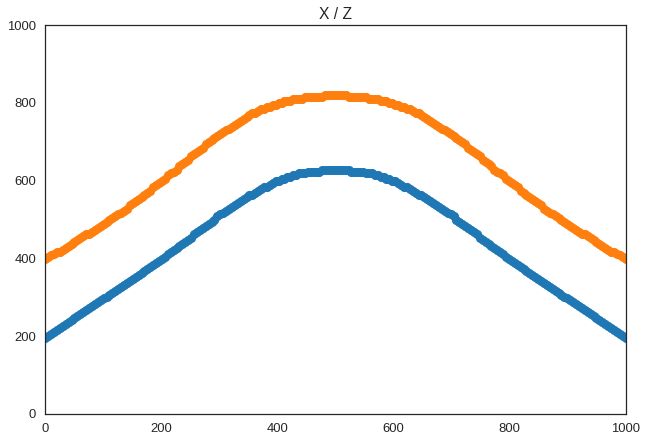

In [21]:
fig, (ax1) = plt.subplots(1, 1)

for key in tops_dict.keys():
    
    xyz = tops_dict[key]
    ax1.plot(
        xyz[0],
        xyz[2],
        'o'
    )

ax1.set_title('X / Z')
ax1.set_xlim(0,1000)
ax1.set_ylim(0,1000)
plt.show()